# Creacion del seguidor de fase

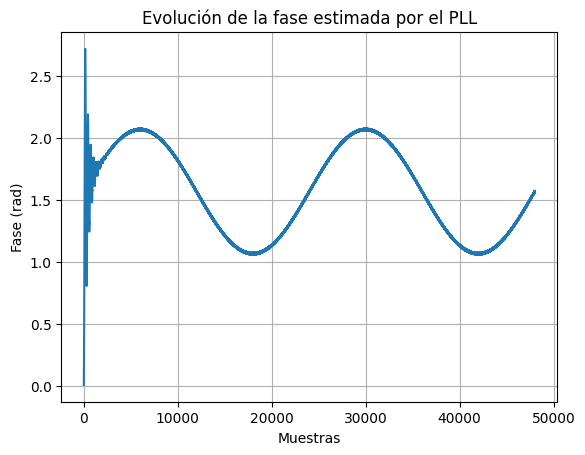

In [658]:
import numpy as np

def binario_a_ascii(binario):
    mensaje = ''.join(chr(int(binario[i:i+8], 2)) for i in range(0, len(binario), 8))
    return mensaje

def pll_track_phase(signal, fs, fc, Kp=0.01, Ki=0.001):
    """
    PLL muy simple para estimar la fase de una portadora conocida fc.
    Devuelve:
      - phase_hist: evolución de la fase estimada por muestra
      - phase_final: fase final estimada
    """

    N = len(signal)
    phase = 0.0         # fase inicial
    integ = 0.0         # término integral
    phase_hist = np.zeros(N)
    w0 = 2 * np.pi * fc / fs  # frecuencia normalizada

    for n in range(N):
        # oscilador local
        lo = np.cos(w0 * n + phase)

        # detector de fase simple: error ~ producto señal * lo
        error = signal[n] * lo

        # lazo PI
        integ += Ki * error
        phase += Kp * error + integ

        phase_hist[n] = phase

    phase_final = phase_hist[-1]
    return phase_hist, phase_final
# prueba de la función pll_track_phase
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    fs = 48000
    fc = 3000
    t = np.arange(0, 1.0, 1/fs)
    # señal portadora con fase variable
    signal = np.cos(2 * np.pi * fc * t + 0.5 * np.sin(2 * np.pi * 2 * t))

    phase_hist, phase_final = pll_track_phase(signal, fs, fc)

    plt.figure()
    plt.plot(phase_hist)
    plt.title("Evolución de la fase estimada por el PLL")
    plt.xlabel("Muestras")
    plt.ylabel("Fase (rad)")
    plt.grid()
    plt.show()

# creacion del Coseno levantado

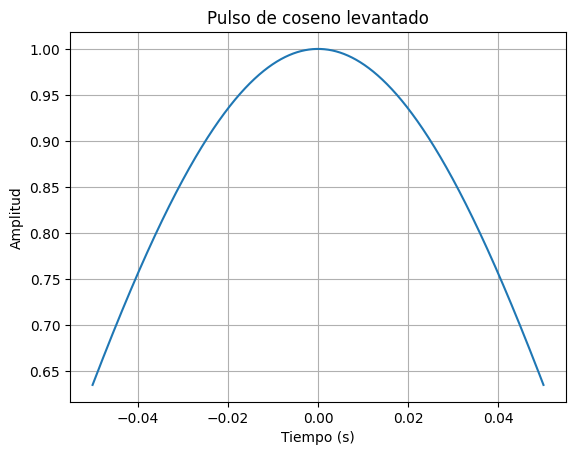

In [659]:
import sounddevice as sd
import matplotlib.pyplot as plt
def raised_cosine_pulse(Tb, fs, beta=0.25):
    N = int(Tb * fs)
    t = np.linspace(-Tb/2, Tb/2, N)

    h = np.zeros(N)
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1.0
        elif abs(1 - (2 * beta * ti/Tb)**2) < 1e-8:
            h[i] = (np.pi/4) * np.sinc(1/(2*beta))
        else:
            h[i] = (np.sin(np.pi * ti / Tb) / (np.pi * ti / Tb)) * \
                   (np.cos(np.pi * beta * ti / Tb) /
                    (1 - (2 * beta * ti / Tb)**2))

    return h, N
 # Prueba de la función raised_cosine_pulse
if __name__ == "__main__":
    Tb = 0.1
    fs = 48000
    beta = 0.1

    pulse, N = raised_cosine_pulse(Tb, fs, beta)

    t = np.linspace(-Tb/2, Tb/2, N)
    plt.figure()
    plt.plot(t, pulse)
    plt.title("Pulso de coseno levantado")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

# Funcion de modulacion 8psk

In [660]:
def modulate_16qam(bits, Tb, fs, fc, beta=0.25):
    """
    Modula una cadena de bits usando 16QAM + Raised Cosine.

    bits : str       Cadena de bits (múltiplo de 4)
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    # Verificación
    if len(bits) % 4 != 0:
        raise ValueError("La cantidad de bits debe ser múltiplo de 4 para 16QAM.")

    # --- Mapeo Gray 4 bits → (I, Q) ---
    mapping = {
        "0000": (-3, -3),
        "0001": (-3, -1),
        "0011": (-3, 1),
        "0010": (-3, 3),
        "0110": (-1, 3),
        "0111": (-1, 1),
        "0101": (-1, -1),
        "0100": (-1, -3),
        "1100": (1, -3),
        "1101": (1, -1),
        "1111": (1, 1),
        "1110": (1, 3),
        "1010": (3, 3),
        "1011": (3, 1),
        "1001": (3, -1),
        "1000": (3, -3),
    }

    symbols = [bits[i:i+4] for i in range(0, len(bits), 4)]
    IQ_pairs = np.array([mapping[s] for s in symbols])

    I_symbols = IQ_pairs[:, 0]
    Q_symbols = IQ_pairs[:, 1]

    # --- Pulso Raised Cosine ---
    h, N = raised_cosine_pulse(Tb, fs, beta)

    total_samples = len(symbols) * N
    t = np.linspace(0, Tb * len(symbols), total_samples, endpoint=False)

    # Señales I(t) y Q(t)
    I = np.zeros(total_samples)
    Q = np.zeros(total_samples)

    for k in range(len(symbols)):
        I0 = I_symbols[k]
        Q0 = Q_symbols[k]

        start = k * N
        end = start + N
        I[start:end] += I0 * h
        Q[start:end] += Q0 * h
    # --- Modulación pasabanda ---
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)    
    # Señal 16QAM pasabanda
    s = I * carrier_cos - Q * carrier_sin
    return t, s, I, Q



# Creacion del detector de sonido

🎙 Grabando desde el micrófono por máximo 10 s...
✔ Grabación finalizada.


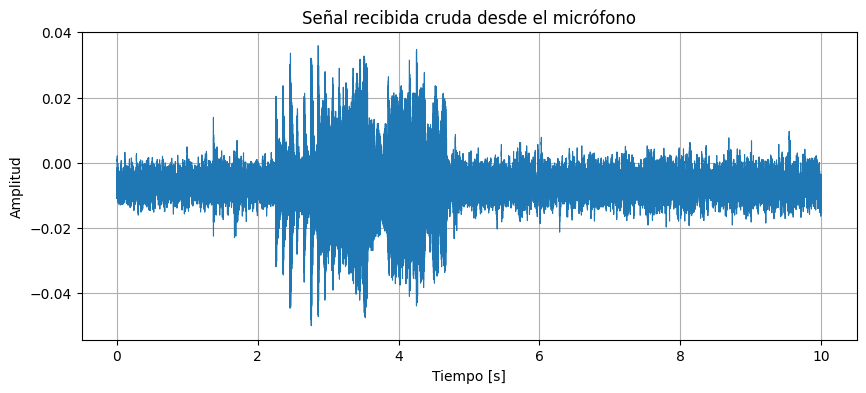

In [661]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt

def record_and_receive_16qam(
    Tb=0.005,
    fs=48000,
    fc=12000,
    beta=0.25,
    max_duration=10.0
):

    print(f"🎙 Grabando desde el micrófono por máximo {max_duration} s...")
    num_samples = int(max_duration * fs)
    recording = sd.rec(num_samples, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")

    # Señal cruda tal cual la entregó el micrófono
    rx = recording[:, 0]

    # ===== 0. GRAFICAR SEÑAL CRUDA =====
    t_full = np.arange(len(rx)) / fs

    plt.figure(figsize=(10,4))
    plt.plot(t_full, rx, linewidth=0.8)
    plt.title("Señal recibida cruda desde el micrófono")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()


    return t_full, rx,

START_BITS = "000"   # preámbulo de inicio
END_BITS   = "000"      # trama final
Tb=0.1
fs=48000
fc=3000
beta=0.25
max_duration=10
t_full, rx= record_and_receive_16qam(
    Tb=1,
    fs=48000,
    fc=3000,
    beta=0.25,
    max_duration=10
)



# Filtro pasa banda

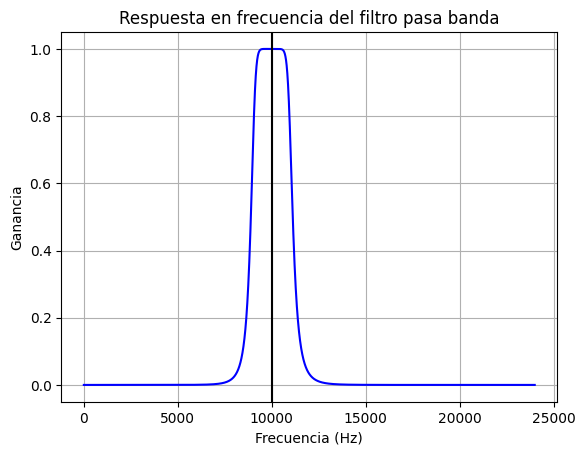

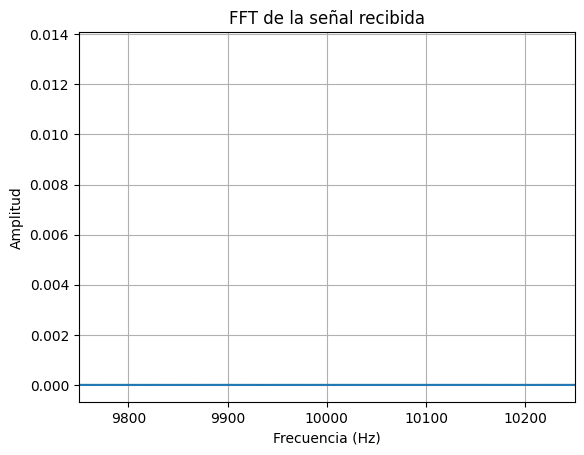

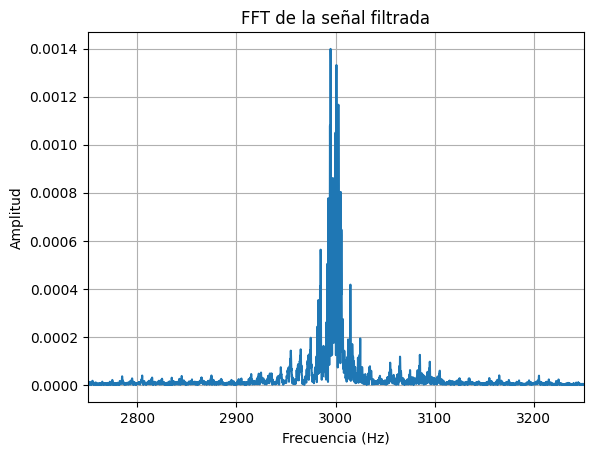

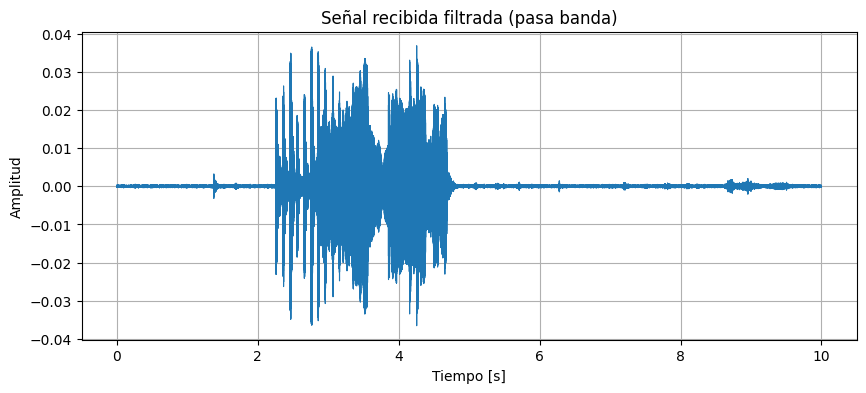

In [662]:
# Crear filtro pasa banda
from scipy.signal import butter, lfilter, freqz
def bandpass_filter(signal, fs, fc, bandwidth=2000, order=5):
    nyq = 0.5 * fs
    low = (fc - bandwidth/2) / nyq
    high = (fc + bandwidth/2) / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

# Respuesta natural del filtro
f = 10000  # frecuencia central
b, a = butter(5, [(f - 1000)/(48000/2), (f + 1000)/(48000/2)], btype='band')
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# barra de frecuencia de corte
plt.axvline(f, color='k')
plt.title("Respuesta en frecuencia del filtro pasa banda")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia')
plt.grid()
plt.show()

# FFt de la señal recibida
from scipy.fft import fft, fftfreq
N = len(rx)
T = 1.0 / fs
yf = fft(rx)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title("FFT de la señal recibida")
plt.xlabel("Frecuencia (Hz)")
plt.xlim(f-250, f+250)
plt.ylabel("Amplitud")
plt.grid()  
plt.show()

# Aplicar filtro pasa banda
x = bandpass_filter(rx, fs, 3000, bandwidth=1000, order=5)
# FFT de la señal filtrada
yf_filt = fft(x)
plt.plot(xf, 2.0/N * np.abs(yf_filt[0:N//2]))
plt.title("FFT de la señal filtrada")
plt.xlabel("Frecuencia (Hz)")
plt.xlim(3000-250, 3000+250)
plt.ylabel("Amplitud")
plt.grid()
plt.show()
# Señal filtrada en el tiempo
plt.figure(figsize=(10,4))
plt.plot(t_full, x, linewidth=0.8)
plt.title("Señal recibida filtrada (pasa banda)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

# Detectar inicio:

Umbral establecido en: 30000
Mensaje detectado entre 2.26 s y 4.66 s


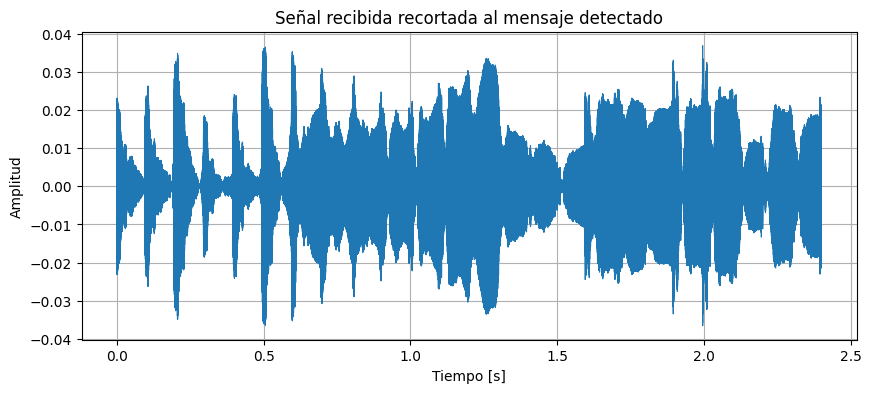

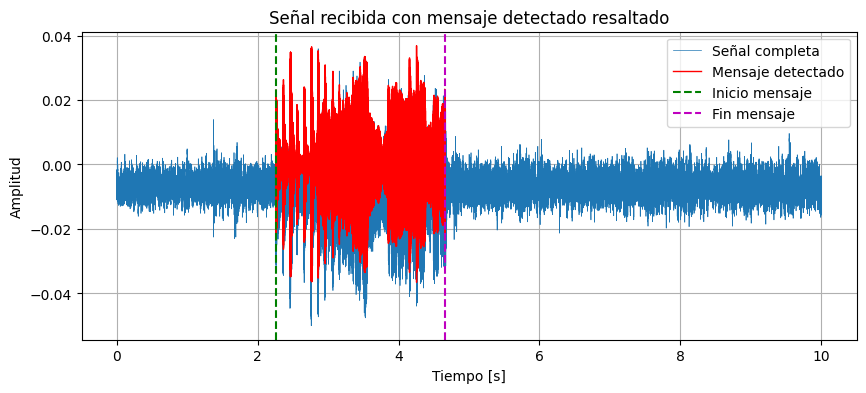

In [663]:
def goertzel(x, fs, f_target):
    N = len(x)
    k = int(0.5 + (N * f_target) / fs)
    w = (2*np.pi / N) * k
    s_prev = 0
    s_prev2 = 0
    for n in range(N):
        s = x[n] + 2*np.cos(w)*s_prev - s_prev2
        s_prev2 = s_prev
        s_prev = s
    return s_prev2**2 + s_prev**2 - 2*np.cos(w)*s_prev*s_prev2
fs = 48000
fc = 3000
window = int(0.02 * fs)    # 20 ms

power = []
for i in range(0, len(x)-window, window):
    chunk = x[i:i+window]
    power.append(goertzel(chunk, fs, fc))
power = np.array(power)
noise = power[:int(1.0/(0.02))]  # 1 segundo de ruido
test = 30000
while True:
    try: 
        umbral = noise.mean() + test*noise.std()
        print(f"Umbral establecido en: {test}")
        indices = np.where(power > umbral)[0]
        start = indices[0] * 0.02
        end   = indices[-1] * 0.02
        break
    except:
        test = int(test/2)


print(f"Mensaje detectado entre {start:.2f} s y {end:.2f} s")
# recortar señal al mensaje detectado
start_sample = int(start * fs)
end_sample   = int(end * fs)
rx_msg = x[start_sample:end_sample]
t_msg = np.arange(len(rx_msg)) / fs
plt.figure(figsize=(10,4))
plt.plot(t_msg, rx_msg, linewidth=0.8)
plt.title("Señal recibida recortada al mensaje detectado")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()
# Mostrar ventaja de audio recortada
plt.figure(figsize=(10,4))
plt.plot(t_full, rx, linewidth=0.5, label="Señal completa")
plt.plot(t_msg + start, rx_msg, color='r', linewidth=1.0, label="Mensaje detectado")
# Aplicar lineas donde se detecto el mensaje
plt.axvline(start, color='g', linestyle='--', label="Inicio mensaje")
plt.axvline(end, color='m', linestyle='--', label="Fin mensaje")
plt.title("Señal recibida con mensaje detectado resaltado")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()

Fase estimada por el PLL: -14.75 rad


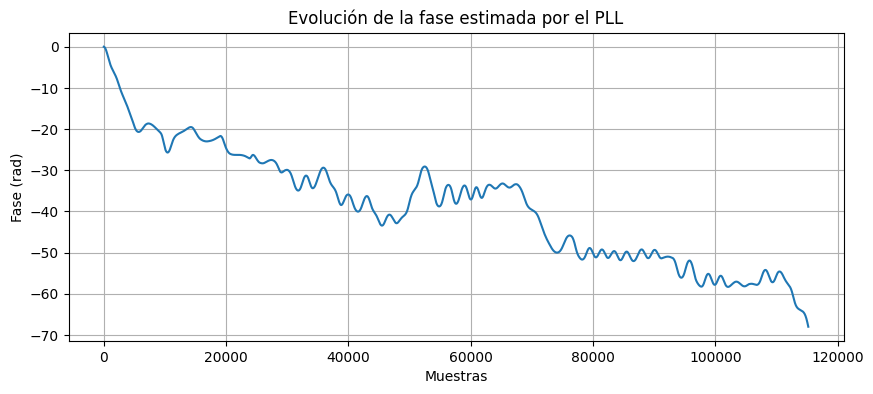

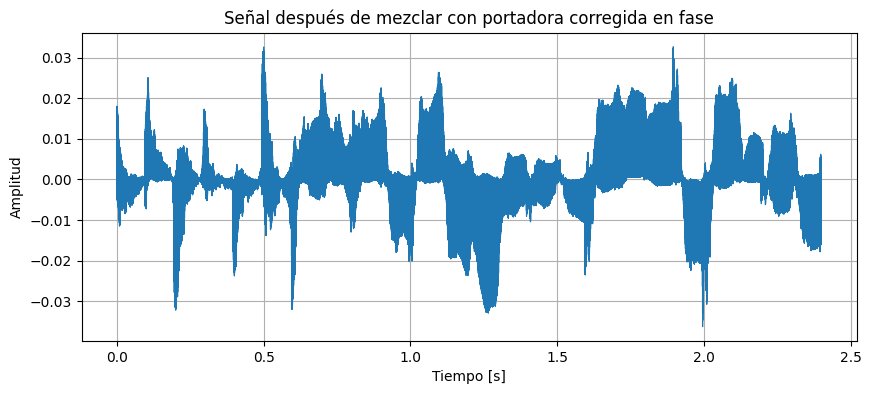

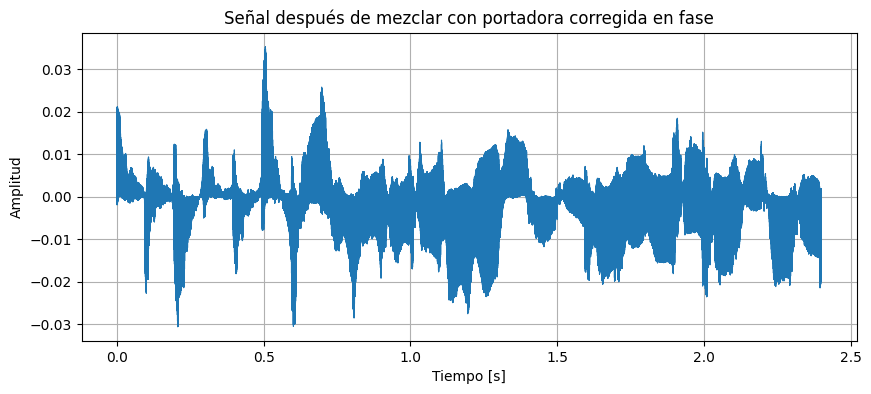

In [664]:
# Aplicar pll para corregir fase
phase_hist, phase_final = pll_track_phase(rx_msg, fs, fc, Kp=0.01, Ki=0.001)
# Usar las fase de las primeras 10000 muestras para corregir
phase_correction = np.mean(phase_hist[:10000])
# Fase estimada
print(f"Fase estimada por el PLL: {phase_correction:.2f} rad")
# Graficar evolución de la fase estimada
plt.figure(figsize=(10,4))
plt.plot(phase_hist)
plt.title("Evolución de la fase estimada por el PLL")
plt.xlabel("Muestras")
plt.ylabel("Fase (rad)")
plt.grid()
plt.show()

# Multiplicar por portadora corregida en fase
portadora_cos = np.cos(2 * np.pi * fc * t_msg + phase_correction)
portadora_sin = np.sin(2 * np.pi * fc * t_msg + phase_correction)
test = rx_msg * portadora_cos
plt.figure(figsize=(10,4))
plt.plot(t_msg, test, linewidth=0.8)
plt.title("Señal después de mezclar con portadora corregida en fase")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()
test = rx_msg * portadora_sin
plt.figure(figsize=(10,4))
plt.plot(t_msg, test, linewidth=0.8)
plt.title("Señal después de mezclar con portadora corregida en fase")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

# Demodular

Se detectaron 24 simbolos


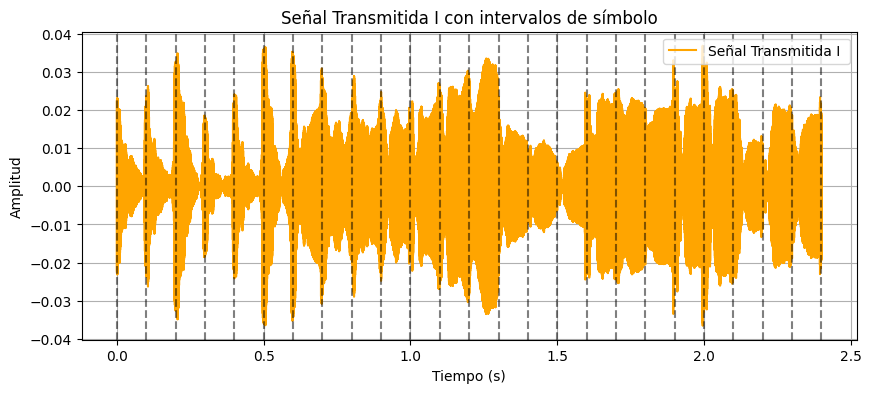

In [665]:
# Multiplicar la señal modulada por las portadoras I y Q
Portadora_I = np.cos(2 * np.pi * fc * t_msg + phase_correction)
Portadora_Q = np.sin(2 * np.pi * fc * t_msg + phase_correction)
Pre_Filtro_I = rx_msg* Portadora_I  # Simulación de la transmisión
Pre_Filtro_Q = rx_msg * Portadora_Q  # Simulación de la transmisión


cantidad_de_simbolo= int(len(t_msg)/(Tb*fs))
print(f"Se detectaron {cantidad_de_simbolo} simbolos")
# Graficar i con los intervalos de cada símbolo
plt.figure(figsize=(10,4))
plt.plot(t_msg, rx_msg, label='Señal Transmitida I ', color='orange')
for i in range (0, cantidad_de_simbolo+1):
    plt.axvline(i*Tb, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Transmitida I con intervalos de símbolo')
plt.legend()
plt.grid(True)
plt.show()
duracion_simbolo = int(len(rx_msg) / cantidad_de_simbolo)


# Integrador

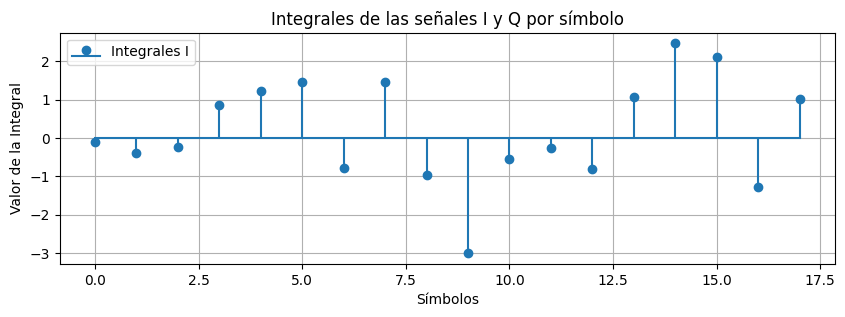

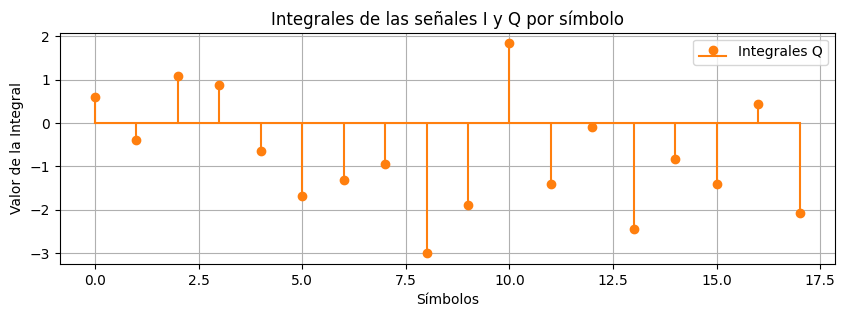

In [666]:
# Integrar para extrar los símbolos I y Q
integral_I = []
for i in range(len(rx_msg )//duracion_simbolo):
    start = i * duracion_simbolo
    end = start + duracion_simbolo
    integral = np.trapezoid(Pre_Filtro_I[start:end], dx=1/fs)
    integral_I.append(integral)
integral_Q = []
for i in range(len(rx_msg) // duracion_simbolo):
    start = i * duracion_simbolo
    end = start + duracion_simbolo
    integral = np.trapezoid(Pre_Filtro_Q[start:end], dx=1/fs)
    integral_Q.append(integral)
# Normalizar a 1 -1
max_I = max(abs(min(integral_I)), abs(max(integral_I)))
integral_I = [i / max_I*3 for i in integral_I]
max_Q = max(abs(min(integral_Q)), abs(max(integral_Q)))
integral_Q = [i / max_Q*3 for i in integral_Q]
# Graficar las integrales obtenidas
# Ignorar los 3 primeros símbolos (preámbulo) y los 3 últimos (final)
integral_I = integral_I[3:-3]
integral_Q = integral_Q[3:-3]
plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_I)), integral_I, linefmt='C0-', markerfmt='C0o', basefmt='C0-', label='Integrales I')

plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I y Q por símbolo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_Q)), integral_Q, linefmt='C1-', markerfmt='C1o', basefmt='C1-', label='Integrales Q')
plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I y Q por símbolo')
plt.legend()
plt.grid(True)
plt.show()

# Decodificar

In [671]:
# Extraer los simbolos I y Q decidiendo el valor más cercano
decisiones_I = []
for val in integral_I:
    if val < -2:
        decisiones_I.append(-3)
    elif -2 <= val < 0:
        decisiones_I.append(-1)
    elif 0 <= val < 2:
        decisiones_I.append(1)
    else:
        decisiones_I.append(3)
decisiones_Q = []
for val in integral_Q:
    if val < -2:
        decisiones_Q.append(-3)
    elif -2 <= val < 0:
        decisiones_Q.append(-1)
    elif 0 <= val < 2:
        decisiones_Q.append(1)
    else:
        decisiones_Q.append(3)
# Mapear de (I, Q) a bits usando el mapeo Gray inverso
mapping_inv = {
    (-3, -3): "0000",
    (-3, -1): "0001",
    (-3, 1): "0011",
    (-3, 3): "0010",
    (-1, 3): "0110",
    (-1, 1): "0111",
    (-1, -1): "0101",
    (-1, -3): "0100",
    (1, -3): "1100",
    (1, -1): "1101",
    (1, 1): "1111",
    (1, 3): "1110",
    (3, 3): "1010",
    (3, 1): "1011",
    (3, -1): "1001",
    (3, -3): "1000",
}
bits_recibidos = ""
for i in range(len(decisiones_I)):
    pareja = (decisiones_I[i], decisiones_Q[i])
    bits_recibidos += mapping_inv[pareja]
print(f"Bits recibidos: {bits_recibidos}")

# decodificar a ascii
print(f"bits decodificados {binario_a_ascii(bits_recibidos)}")

Bits recibidos: 011101010111111111011101010111010100000101110101010111001001100101111100
bits decodificados uÝ]Au\|
